# Recording a Gesture for Shimi

First, run the cell below to instatiate the shimi object. It should move to its initial positions and then relax.

In [1]:
# Import some matplolib shortcuts for Jupyter notebook
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from shimi import *
from motion.move import *
from config.definitions import *
from motion.recorder import *
from motion.playback import *
from audio.audio import *
from posenet.posenet import *

import time
import datetime

from copy import deepcopy

import os

import threading

# Load Shimi
shimi = Shimi()

local_gestures = {}

Connecting on /dev/tty.usbmodem143101
Found motors with the following IDs: [1, 2, 3, 4, 5]
(OrderedDict([('model', 'MX-28'),
              ('firmware', 30),
              ('id', 1),
              ('baudrate', 1),
              ('return delay time', 0),
              ('angle limit', (-99.03, 14.64)),
              ('highest temperature limit', 80.0),
              ('voltage limit', (6.0, 16.0)),
              ('max torque', 100.0),
              ('status return level', 'always'),
              ('alarm LED', ('Overload Error', 'Overheating Error')),
              ('alarm shutdown', ('Overload Error', 'Overheating Error')),
              ('torque_enable', True),
              ('LED', False),
              ('pid gain', (0.0, 0.0, 4.0)),
              ('goal position', 9.36),
              ('moving speed', 0.684),
              ('torque limit', 100.0),
              ('present position', 9.89),
              ('present speed', 0.0),
              ('present load', 5.5),
              ('present

The cell below defines the recorder object. The first parameter is a reference to the motor controller, the second is a **list** of motor ids, referenced by a convenience property on `shimi`. The options are as follows:
* `shimi.torso`
* `shimi.neck_lr`
* `shimi.neck_ud`
* `shimi.phone`
* `shimi.foot`
* `shimi.all_motors`: this **returns a list**, so you don't need to wrap it in one in this call


The final parameter is the duration for which you want to record.

In [2]:
r = Recorder(shimi, shimi.all_motors, 3.0)
r1 = Recorder(shimi, shimi.all_motors, 3.0)

This starts a recording. It will count down from 3 to let you know when the recording starts, then move Shimi as you want it to move. **The first thing this call does is relax the motors, so be sure it doesn't collapse on itself when you call this.**

3.0...
2.0...
1.0...
Recording...
Done. Recorded 452 positions and 452 velocities.


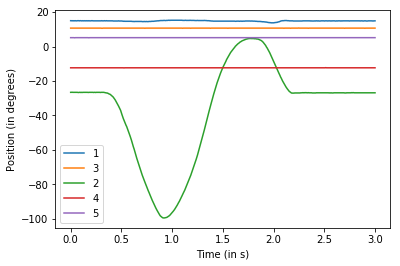

In [5]:
r.record()
r.plot(plt.axes())

Then, run this to play back the recorded gesture.

In [ ]:
r.play(plt.axes())

### Here are some helper functions.

In [ ]:
# Puts shimi in a neutral position with motors non-compliant
shimi.initial_position()

## **Make sure Shimi will not collapse before you run this!!!**

In [ ]:
# Makes the motors compliant
shimi.disable_torque()

### Here's a hard-coded demo of Shimi dancing to Hey Ya

In [ ]:
play_outkast(shimi)

In [ ]:
play_opera(shimi)

In [ ]:
p = PoseNet(shimi)

In [ ]:
p.record()

In [ ]:
p.play(None, plt.axes())

In [ ]:
p.stop_posenet()

In [ ]:
m = LinearMove(shimi, shimi.torso, 1.0, 1.0, normalized_positions=True)
m.start()

In [ ]:
playback(shimi, r.motors, r.dur, r.timestamps, r.positions, r.velocities, plt.axes())

In [ ]:
r.append_recording(r1)

In [4]:
r.save("test")

In [ ]:
old_r = load_recorder(shimi, "test")